In [1]:
%matplotlib inline


# Kernel Density Estimate of Species Distributions

This shows an example of a neighbors-based query (in particular a kernel
density estimate) on geospatial data, using a Ball Tree built upon the
Haversine distance metric -- i.e. distances over points in latitude/longitude.
The dataset is provided by Phillips et. al. (2006).
If available, the example uses
`basemap <http://matplotlib.org/basemap>`_
to plot the coast lines and national boundaries of South America.

This example does not perform any learning over the data
(see :ref:`sphx_glr_auto_examples_applications_plot_species_distribution_modeling.py` for
an example of classification based on the attributes in this dataset).  It
simply shows the kernel density estimate of observed data points in
geospatial coordinates.

The two species are:

 - `"Bradypus variegatus"
   <http://www.iucnredlist.org/apps/redlist/details/3038/0>`_ ,
   the Brown-throated Sloth.

 - `"Microryzomys minutus"
   <http://www.iucnredlist.org/details/13408/0>`_ ,
   also known as the Forest Small Rice Rat, a rodent that lives in Peru,
   Colombia, Ecuador, Peru, and Venezuela.

References
----------

 * `"Maximum entropy modeling of species geographic distributions"
   <http://www.cs.princeton.edu/~schapire/papers/ecolmod.pdf>`_
   S. J. Phillips, R. P. Anderson, R. E. Schapire - Ecological Modelling,
   190:231-259, 2006.


 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


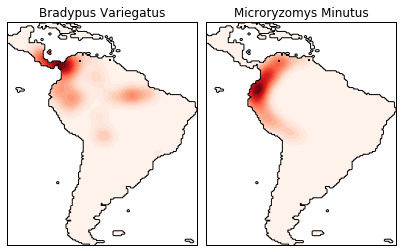

In [2]:
# Author: Jake Vanderplas <jakevdp@cs.washington.edu>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = -9999 + np.zeros(land_mask.shape[0])
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9999], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()